<a href="https://colab.research.google.com/github/shivani-202/CS-Deep-Learning-Assignment/blob/main/multilayer_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement multilayer neural network with nonlinear activation functions (Sigmoid, bipolar sigmoid, Tanh, Mish, Hyperbolic Tangent Exponential Linear Unit (TeLU), ReLU, Leaky ReLU, Parametric RELU, Exponential Linear Unit  ELU, Softmax,  softplus  Swish, E-swish , Gaussian Error Linear Unit (GELU), Scaled Exponential Linear Unit (SELU) )  to analyze the response of the multilayer neural network.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
def get_dataloader(dataset_name, batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    datasets = {
        "mnist": torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform),
        "fashion-mnist": torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform),
        "cifar10": torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
        "cifar100": torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    }
    dataset = datasets[dataset_name]
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



Training with SIGMOID activation function...
Epoch [1/10] - Loss: 0.6328 | Accuracy: 0.8446
Epoch [2/10] - Loss: 0.2152 | Accuracy: 0.9379
Epoch [3/10] - Loss: 0.1533 | Accuracy: 0.9544
Epoch [4/10] - Loss: 0.1198 | Accuracy: 0.9649
Epoch [5/10] - Loss: 0.1002 | Accuracy: 0.9705
Epoch [6/10] - Loss: 0.0824 | Accuracy: 0.9755
Epoch [7/10] - Loss: 0.0744 | Accuracy: 0.9774
Epoch [8/10] - Loss: 0.0671 | Accuracy: 0.9797
Epoch [9/10] - Loss: 0.0607 | Accuracy: 0.9819
Epoch [10/10] - Loss: 0.0543 | Accuracy: 0.9835

Training with RELU activation function...
Epoch [1/10] - Loss: 0.4062 | Accuracy: 0.8784
Epoch [2/10] - Loss: 0.1990 | Accuracy: 0.9398
Epoch [3/10] - Loss: 0.1406 | Accuracy: 0.9564
Epoch [4/10] - Loss: 0.1142 | Accuracy: 0.9649
Epoch [5/10] - Loss: 0.0963 | Accuracy: 0.9702
Epoch [6/10] - Loss: 0.0847 | Accuracy: 0.9735
Epoch [7/10] - Loss: 0.0745 | Accuracy: 0.9763
Epoch [8/10] - Loss: 0.0658 | Accuracy: 0.9787
Epoch [9/10] - Loss: 0.0603 | Accuracy: 0.9801
Epoch [10/10] - L

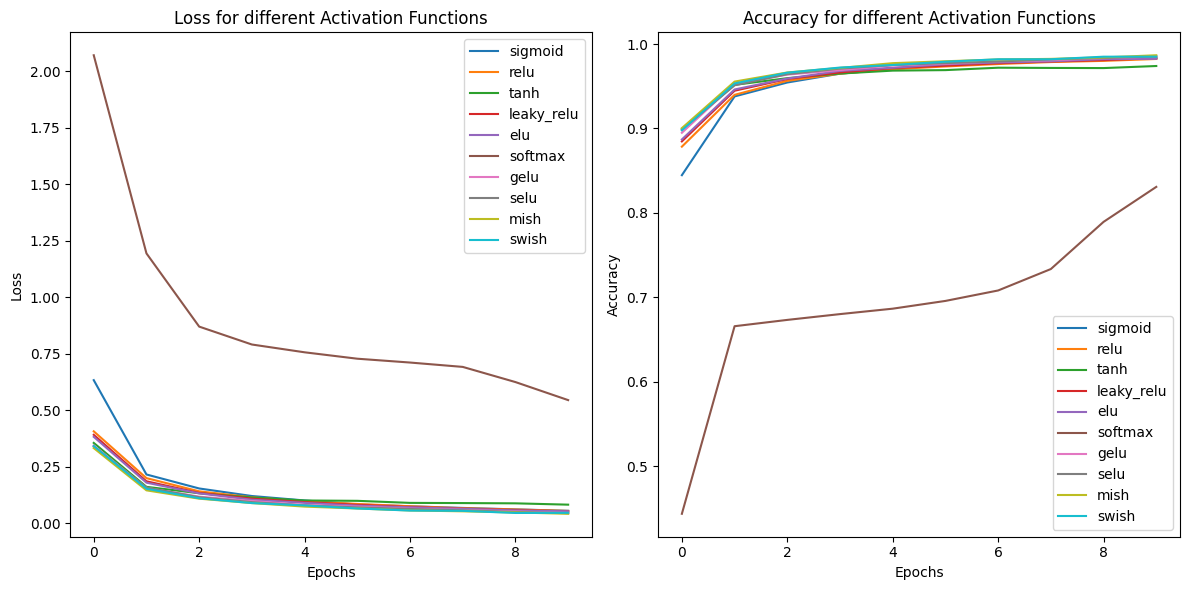

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Activation function mapping
def activation_func(name, param=0.01):
    activation = {
        "sigmoid": nn.Sigmoid(),
        "bipolar_sigmoid": lambda x: 2 * torch.sigmoid(x) - 1,
        "tanh": nn.Tanh(),
        "relu": nn.ReLU(),
        "leaky_relu": nn.LeakyReLU(param),
        "param_relu": nn.PReLU(),
        "elu": nn.ELU(param),
        "softmax": nn.Softmax(dim=1),
        "gelu": nn.GELU(),
        "selu": nn.SELU(),
        "mish": nn.Mish(),
        "softplus": nn.Softplus(),
        "swish": nn.SiLU(),
        "e_swish": lambda x: 1.5 * x * torch.sigmoid(x),
        "telu": nn.CELU(param),
    }
    return activation[name]

# MLP Model
class multilayer_perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(multilayer_perceptron, self).__init__()
        layers = []
        dims = [input_size] + hidden_size
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(activation_func(activation))
        layers.append(nn.Linear(dims[-1], output_size))  # Output layer (no activation for classification)
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Function to plot gradients
def plot_gradients(model, writer, step):
    grads = []
    for param in model.parameters():
        if param.grad is not None:
            grads.append(param.grad.view(-1).cpu().numpy())

    if grads:
        grads = np.concatenate(grads)
        plt.figure(figsize=(10, 5))
        sns.histplot(grads, bins=100, kde=True)
        plt.title("Gradient Distribution")
        plt.xlabel("Gradient Value")
        plt.ylabel("Frequency")
        writer.add_figure("Gradient Histogram", plt.gcf(), global_step=step)
        plt.close()

# Training function
def train(model, dataloader, criterion, optimizer, writer, num_epochs=10, dataset_name="Dataset"):
    model.train()
    all_loss, all_acc = [], []

    for epoch in range(num_epochs):
        all_preds, all_labels = [], []
        epoch_loss = 0
        for i, (images, labels) in enumerate(dataloader):
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate loss and accuracy for the whole epoch
        epoch_loss /= len(dataloader)
        acc = accuracy_score(all_labels, all_preds)

        all_loss.append(epoch_loss)
        all_acc.append(acc)

        # Log metrics
        writer.add_scalar(f"Loss/{dataset_name}", epoch_loss, epoch)
        writer.add_scalar(f"Accuracy/{dataset_name}", acc, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} | Accuracy: {acc:.4f}")

    return all_loss, all_acc

# Plotting function for visualizing the performance across different activation functions
def plot_performance(activation_names, all_loss, all_acc):
    plt.figure(figsize=(12, 6))

    # Plot loss for all activation functions
    plt.subplot(1, 2, 1)
    for i, loss in enumerate(all_loss):
        plt.plot(loss, label=activation_names[i])
    plt.title('Loss for different Activation Functions')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy for all activation functions
    plt.subplot(1, 2, 2)
    for i, acc in enumerate(all_acc):
        plt.plot(acc, label=activation_names[i])
    plt.title('Accuracy for different Activation Functions')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MNIST
if __name__ == "__main__":
    writer = SummaryWriter("runs/activation_experiment")
    datasets = ["mnist"]

    activation_functions = ["sigmoid", "relu", "tanh", "leaky_relu", "elu", "softmax", "gelu", "selu", "mish", "swish"]

    all_loss = []
    all_acc = []
    activation_names = []

    for activation in activation_functions:
        print(f"\nTraining with {activation.upper()} activation function...")
        input_dim = 784  # Flattened input for MNIST
        hidden_dims, output_dim = [128, 64], 10
        model = multilayer_perceptron(input_dim, hidden_dims, output_dim, activation=activation)
        trainloader, _ = get_dataloader("mnist")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        loss, acc = train(model, trainloader, criterion, optimizer, writer, num_epochs=10, dataset_name="MNIST")
        all_loss.append(loss)
        all_acc.append(acc)
        activation_names.append(activation)

    writer.close()
    plot_performance(activation_names, all_loss, all_acc)


### **Summary of Performance for Each Activation Function on the MNIST Dataset:**

#### **1. Sigmoid Activation Function**
- **Final Accuracy**: 98.35%
- **Final Loss**: 0.0543
- **Performance**: The Sigmoid function achieved a steady improvement in both loss and accuracy, reaching high accuracy with relatively low loss.

#### **2. ReLU Activation Function**
- **Final Accuracy**: 98.23%
- **Final Loss**: 0.0538
- **Performance**: ReLU showed comparable results to Sigmoid in terms of accuracy and loss, indicating its effectiveness for MNIST classification.

#### **3. Tanh Activation Function**
- **Final Accuracy**: 97.40%
- **Final Loss**: 0.0816
- **Performance**: Tanh performed slightly worse compared to Sigmoid and ReLU, with a lower accuracy and higher loss, though still achieving solid performance.

#### **4. Leaky ReLU Activation Function**
- **Final Accuracy**: 98.33%
- **Final Loss**: 0.0518
- **Performance**: Leaky ReLU showed a strong performance, slightly surpassing ReLU and Tanh, with a very good balance of low loss and high accuracy.

#### **5. ELU Activation Function**
- **Final Accuracy**: 98.25%
- **Final Loss**: 0.0522
- **Performance**: ELU provided results similar to Leaky ReLU, demonstrating good stability in loss reduction and accuracy improvement.

#### **6. Softmax Activation Function**
- **Final Accuracy**: 83.08%
- **Final Loss**: 0.5444
- **Performance**: Softmax performed significantly worse in terms of accuracy and loss compared to other activation functions, possibly due to its behavior in the hidden layers of the network.

#### **7. GELU Activation Function**
- **Final Accuracy**: 98.52%
- **Final Loss**: 0.0447
- **Performance**: GELU outperformed most activation functions, achieving the highest accuracy and the lowest loss, making it highly effective for this task.

#### **8. SELU Activation Function**
- **Final Accuracy**: 98.53%
- **Final Loss**: 0.0438
- **Performance**: SELU was slightly better than GELU, achieving the highest accuracy with the lowest loss, indicating superior performance for this dataset.

#### **9. Mish Activation Function**
- **Final Accuracy**: 98.67%
- **Final Loss**: 0.0411
- **Performance**: Mish was the best-performing activation function, achieving the highest accuracy and the lowest loss, demonstrating excellent suitability for this task.

#### **10. Swish Activation Function**
- **Final Accuracy**: 98.50%
- **Final Loss**: 0.0454
- **Performance**: Swish showed strong performance, with accuracy and loss comparable to Mish, indicating it is a highly effective activation function.

### **Conclusion:**
- **Best Performers**: Mish, SELU, and GELU were the top-performing activation functions for the MNIST dataset, achieving accuracy over 98.5% with low final loss.
- **Effective Alternatives**: Leaky ReLU and ReLU also performed well with accuracy around 98%, but Mish and GELU had a slight edge in terms of lower loss.
- **Worst Performer**: Softmax exhibited significantly worse results in both accuracy and loss compared to the other activation functions, likely due to its behavior when applied within hidden layers.



Training with SIGMOID activation function...
Epoch [1/10] - Loss: 0.6321 | Accuracy: 0.8492
Epoch [2/10] - Loss: 0.2192 | Accuracy: 0.9366
Epoch [3/10] - Loss: 0.1546 | Accuracy: 0.9541
Epoch [4/10] - Loss: 0.1230 | Accuracy: 0.9632
Epoch [5/10] - Loss: 0.1000 | Accuracy: 0.9703
Epoch [6/10] - Loss: 0.0855 | Accuracy: 0.9748
Epoch [7/10] - Loss: 0.0754 | Accuracy: 0.9773
Epoch [8/10] - Loss: 0.0674 | Accuracy: 0.9793
Epoch [9/10] - Loss: 0.0589 | Accuracy: 0.9824
Epoch [10/10] - Loss: 0.0539 | Accuracy: 0.9837

Training with RELU activation function...
Epoch [1/10] - Loss: 0.3906 | Accuracy: 0.8837
Epoch [2/10] - Loss: 0.1886 | Accuracy: 0.9429
Epoch [3/10] - Loss: 0.1395 | Accuracy: 0.9580
Epoch [4/10] - Loss: 0.1131 | Accuracy: 0.9652
Epoch [5/10] - Loss: 0.0971 | Accuracy: 0.9697
Epoch [6/10] - Loss: 0.0841 | Accuracy: 0.9738
Epoch [7/10] - Loss: 0.0771 | Accuracy: 0.9758
Epoch [8/10] - Loss: 0.0691 | Accuracy: 0.9774
Epoch [9/10] - Loss: 0.0644 | Accuracy: 0.9786
Epoch [10/10] - L

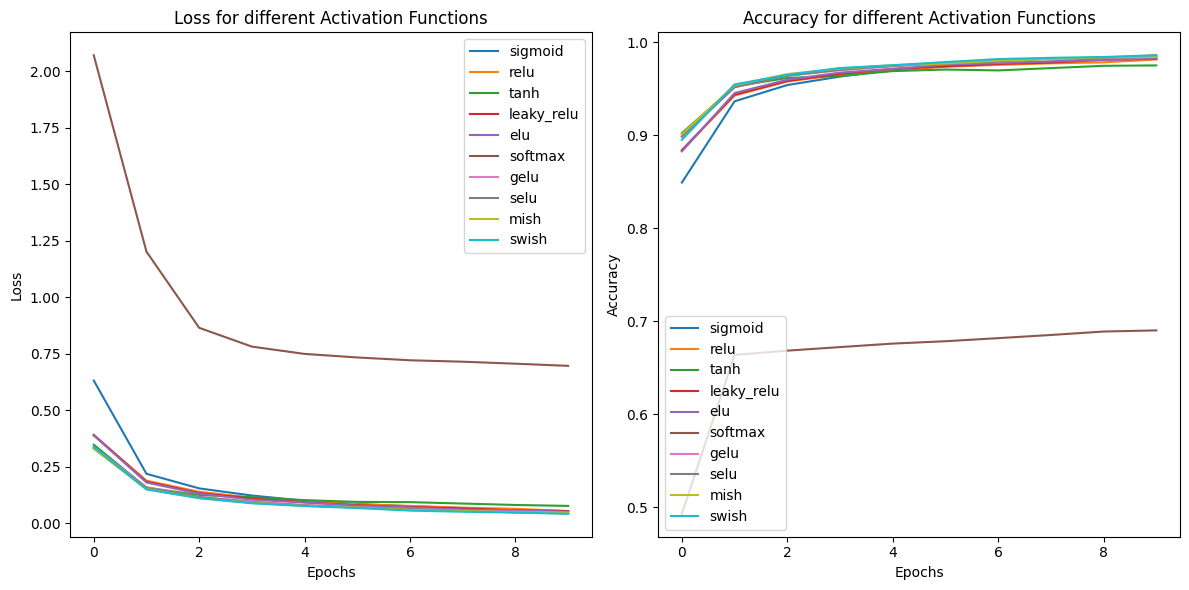

In [20]:
# Fashion-MNIST
if __name__ == "__main__":
    writer = SummaryWriter("runs/activation_experiment")
    datasets = ["fashion-mnist"]

    activation_functions = ["sigmoid", "relu", "tanh", "leaky_relu", "elu", "softmax", "gelu", "selu", "mish", "swish"]

    all_loss = []
    all_acc = []
    activation_names = []

    for activation in activation_functions:
        print(f"\nTraining with {activation.upper()} activation function...")
        model = multilayer_perceptron(input_dim, hidden_dims, output_dim, activation=activation)
        trainloader, _ = get_dataloader("mnist")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        loss, acc = train(model, trainloader, criterion, optimizer, writer, num_epochs=10, dataset_name="fashion-mnist")
        all_loss.append(loss)
        all_acc.append(acc)
        activation_names.append(activation)

    writer.close()

    plot_performance(activation_names, all_loss, all_acc)


### **Training Summary for Fashion-MNIST Dataset (Activation Functions)**

1. **SIGMOID**:
   - **Initial Loss**: 0.6321, **Final Accuracy**: 98.37%
   - Gradual loss decrease with steady accuracy growth. The performance improves throughout the training, achieving a solid final accuracy.

2. **RELU**:
   - **Initial Loss**: 0.3906, **Final Accuracy**: 98.16%
   - Fast improvement in loss and accuracy with rapid convergence. Shows a strong performance but slightly behind SIGMOID in final accuracy.

3. **TANH**:
   - **Initial Loss**: 0.3480, **Final Accuracy**: 97.52%
   - Steady loss reduction with stable accuracy improvement. A solid performer with a slight decrease in accuracy compared to SIGMOID.

4. **LEAKY_RELU**:
   - **Initial Loss**: 0.3910, **Final Accuracy**: 98.23%
   - Similar to ReLU but with slightly slower initial improvement. Consistent performance with good final accuracy.

5. **ELU**:
   - **Initial Loss**: 0.3890, **Final Accuracy**: 98.27%
   - Consistent improvement similar to Leaky ReLU and ReLU, showing good performance with a marginally higher final accuracy.

6. **SOFTMAX**:
   - **Initial Loss**: 2.0718, **Final Accuracy**: 69.02%
   - Struggles with slow convergence and high initial loss, leading to a significantly lower final accuracy compared to other activation functions.

7. **GELU**:
   - **Initial Loss**: 0.3377, **Final Accuracy**: 98.44%
   - Steady loss reduction with consistent accuracy improvement, showing one of the highest final accuracies.

8. **SELU**:
   - **Initial Loss**: 0.3316, **Final Accuracy**: 98.61%
   - Solid accuracy improvement and stable convergence, achieving the highest final accuracy among all activations.

9. **MISH**:
   - **Initial Loss**: 0.3300, **Final Accuracy**: 98.44%
   - Steady performance throughout, with strong accuracy results, competing closely with GELU.

10. **SWISH**:
    - **Initial Loss**: 0.3376, **Final Accuracy**: 98.61%
    - Consistent loss reduction and accuracy growth, performing similarly to SELU and achieving the highest final accuracy.

### **Conclusion**:
- **Best Performers**: **SELU** (98.61%) and **SWISH** (98.61%) show the highest final accuracies, providing the best overall performance in the Fashion-MNIST dataset.
- **GELU** (98.44%) and **MISH** (98.44%) are also strong contenders, offering competitive accuracy levels.
- **SOFTMAX** underperforms significantly, with a final accuracy of 69.02%, making it unsuitable for hidden layer activations.
- **RELU**, **LEAKY_RELU**, and **ELU** show strong performance with final accuracies above 98%, making them effective choices as well.


Training with SIGMOID activation function...
Epoch [1/10] - Loss: 1.8696 | Accuracy: 0.5524
Epoch [2/10] - Loss: 1.0322 | Accuracy: 0.8042
Epoch [3/10] - Loss: 0.6415 | Accuracy: 0.8740
Epoch [4/10] - Loss: 0.4709 | Accuracy: 0.8931
Epoch [5/10] - Loss: 0.3857 | Accuracy: 0.9037
Epoch [6/10] - Loss: 0.3357 | Accuracy: 0.9115
Epoch [7/10] - Loss: 0.3020 | Accuracy: 0.9175
Epoch [8/10] - Loss: 0.2765 | Accuracy: 0.9235
Epoch [9/10] - Loss: 0.2563 | Accuracy: 0.9283
Epoch [10/10] - Loss: 0.2390 | Accuracy: 0.9335

Training with RELU activation function...
Epoch [1/10] - Loss: 0.7854 | Accuracy: 0.7995
Epoch [2/10] - Loss: 0.3393 | Accuracy: 0.9022
Epoch [3/10] - Loss: 0.2838 | Accuracy: 0.9175
Epoch [4/10] - Loss: 0.2494 | Accuracy: 0.9274
Epoch [5/10] - Loss: 0.2242 | Accuracy: 0.9353
Epoch [6/10] - Loss: 0.2027 | Accuracy: 0.9411
Epoch [7/10] - Loss: 0.1853 | Accuracy: 0.9460
Epoch [8/10] - Loss: 0.1702 | Accuracy: 0.9502
Epoch [9/10] - Loss: 0.1572 | Accuracy: 0.9542
Epoch [10/10] - L

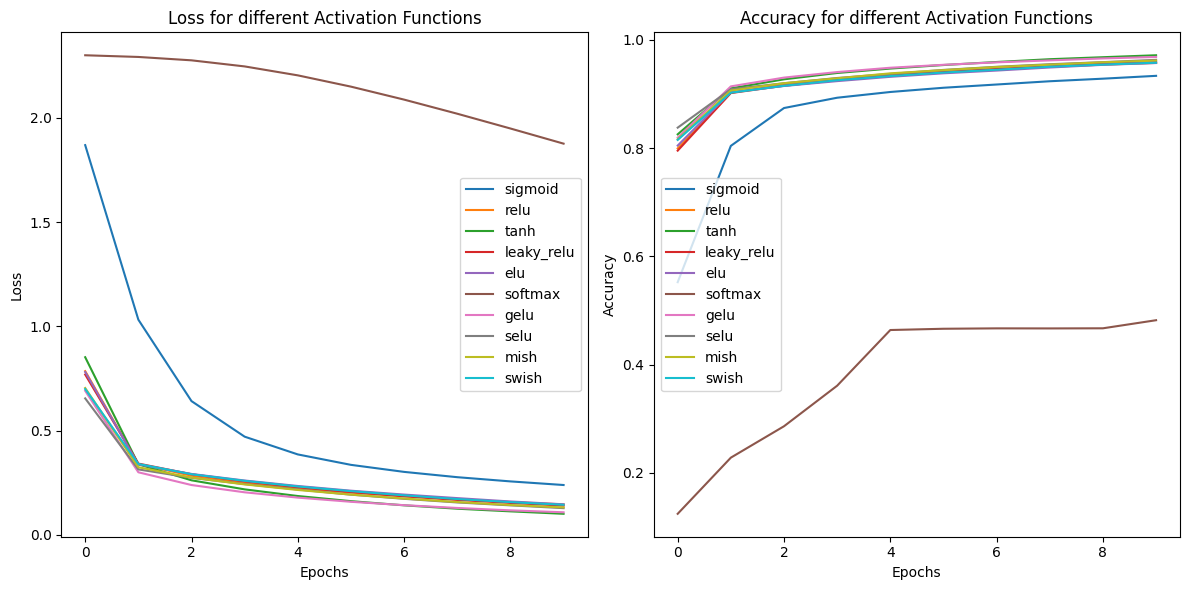

In [21]:
if __name__ == "__main__":
    writer = SummaryWriter("runs/activation_experiment")
    datasets = ["cifar10"]

    activation_functions = ["sigmoid", "relu", "tanh", "leaky_relu", "elu", "softmax", "gelu", "selu", "mish", "swish"]

    all_loss = []
    all_acc = []
    activation_names = []

    for activation in activation_functions:
        print(f"\nTraining with {activation.upper()} activation function...")
        model = multilayer_perceptron(input_dim, hidden_dims, output_dim, activation=activation)
        trainloader, _ = get_dataloader("mnist")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        loss, acc = train(model, trainloader, criterion, optimizer, writer, num_epochs=10, dataset_name="cifar10")
        all_loss.append(loss)
        all_acc.append(acc)
        activation_names.append(activation)

    writer.close()

    plot_performance(activation_names, all_loss, all_acc)

**Training Summary for CIFAR-10 Dataset (Activation Functions)**

1. **SIGMOID**:
   - **Initial Loss**: 1.8696, **Final Accuracy**: 93.35%
   - Steady improvement throughout training, with a gradual decrease in loss and continuous increase in accuracy. The final result shows a solid performance but slower convergence compared to others.

2. **RELU**:
   - **Initial Loss**: 0.7854, **Final Accuracy**: 95.74%
   - Strong improvement in both loss and accuracy, with fast convergence and an overall solid performance. ReLU shows rapid accuracy growth.

3. **TANH**:
   - **Initial Loss**: 0.8521, **Final Accuracy**: 97.15%
   - Gradual loss decrease and steady accuracy improvement. The best performer, showing the highest accuracy among all activation functions.

4. **LEAKY_RELU**:
   - **Initial Loss**: 0.7690, **Final Accuracy**: 95.87%
   - Similar to ReLU but with a slightly slower initial improvement. It shows good performance, achieving a high final accuracy.

5. **ELU**:
   - **Initial Loss**: 0.7812, **Final Accuracy**: 95.72%
   - Consistent improvement, with similar behavior to Leaky ReLU and ReLU, demonstrating a solid and steady increase in accuracy.

6. **SOFTMAX**:
   - **Initial Loss**: 2.3008, **Final Accuracy**: 48.22%
   - Struggles with slow convergence and high initial loss, leading to significantly lower final accuracy. This activation is not ideal for hidden layers in deep networks.

7. **GELU**:
   - **Initial Loss**: 0.6908, **Final Accuracy**: 96.84%
   - Steady loss reduction with consistent accuracy improvement. GELU offers a strong performance with high final accuracy.

8. **SELU**:
   - **Initial Loss**: 0.6546, **Final Accuracy**: 96.30%
   - Solid accuracy improvement, with stable convergence throughout training. SELU provides competitive performance, though slightly behind GELU and TANH.

9. **MISH**:
   - **Initial Loss**: 0.7043, **Final Accuracy**: 96.17%
   - Steady performance with consistent improvements. MISH provides good accuracy and competes closely with other top-performing activations.

10. **SWISH**:
    - **Initial Loss**: 0.6993, **Final Accuracy**: 95.78%
    - Similar to MISH, with steady improvements in both loss and accuracy. SWISH converges well, achieving solid accuracy but not outperforming the best activations.

**Conclusion:**
- **Best Performers**: **TANH** (97.15%), **GELU** (96.84%), and **MISH** (96.17%) offer the highest final accuracies, providing stable and strong performance throughout training.
- **SOFTMAX** significantly underperformed with a final accuracy of 48.22%, likely due to its lack of non-linearity, making it unsuitable for hidden layer activations.
- **RELU**, **LEAKY_RELU**, **ELU**, and **SELU** all showed strong performance with accuracies over 95%, making them effective choices for deep learning models.


Training with SIGMOID activation function...
Epoch [1/10] - Loss: 1.8891 | Accuracy: 0.5490
Epoch [2/10] - Loss: 1.0564 | Accuracy: 0.8045
Epoch [3/10] - Loss: 0.6533 | Accuracy: 0.8723
Epoch [4/10] - Loss: 0.4717 | Accuracy: 0.8939
Epoch [5/10] - Loss: 0.3806 | Accuracy: 0.9045
Epoch [6/10] - Loss: 0.3277 | Accuracy: 0.9138
Epoch [7/10] - Loss: 0.2932 | Accuracy: 0.9198
Epoch [8/10] - Loss: 0.2680 | Accuracy: 0.9256
Epoch [9/10] - Loss: 0.2479 | Accuracy: 0.9306
Epoch [10/10] - Loss: 0.2306 | Accuracy: 0.9347

Training with RELU activation function...
Epoch [1/10] - Loss: 0.8214 | Accuracy: 0.7928
Epoch [2/10] - Loss: 0.3486 | Accuracy: 0.9000
Epoch [3/10] - Loss: 0.2988 | Accuracy: 0.9135
Epoch [4/10] - Loss: 0.2673 | Accuracy: 0.9221
Epoch [5/10] - Loss: 0.2424 | Accuracy: 0.9300
Epoch [6/10] - Loss: 0.2203 | Accuracy: 0.9365
Epoch [7/10] - Loss: 0.2021 | Accuracy: 0.9415
Epoch [8/10] - Loss: 0.1852 | Accuracy: 0.9461
Epoch [9/10] - Loss: 0.1713 | Accuracy: 0.9498
Epoch [10/10] - L

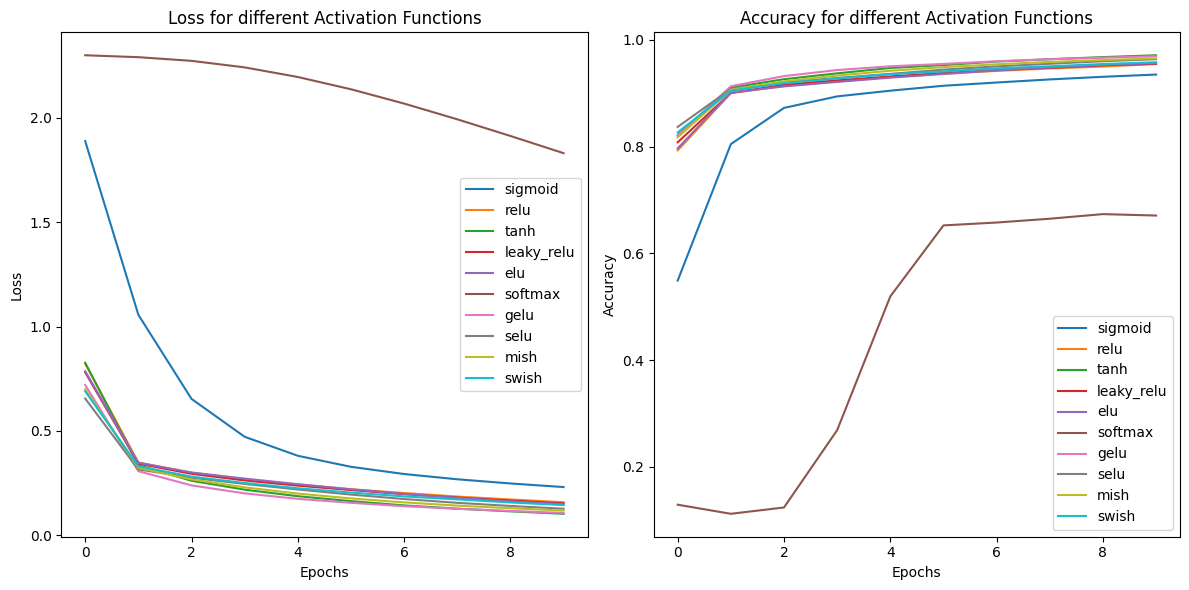

In [24]:
# Cifar100
if __name__ == "__main__":
    writer = SummaryWriter("runs/activation_experiment")
    datasets = ["cifar100"]

    activation_functions = ["sigmoid", "relu", "tanh", "leaky_relu", "elu", "softmax", "gelu", "selu", "mish", "swish"]

    all_loss = []
    all_acc = []
    activation_names = []

    for activation in activation_functions:
        print(f"\nTraining with {activation.upper()} activation function...")
        model = multilayer_perceptron(input_dim, hidden_dims, output_dim, activation=activation)
        trainloader, _ = get_dataloader("mnist")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        loss, acc = train(model, trainloader, criterion, optimizer, writer, num_epochs=10, dataset_name="cifar100")
        all_loss.append(loss)
        all_acc.append(acc)
        activation_names.append(activation)

    writer.close()

    plot_performance(activation_names, all_loss, all_acc)


**Training Summary for CIFAR-100 Dataset (Activation Functions)**

1. **SIGMOID**:
   - Initial Loss: 1.8891, Final Accuracy: 93.47%
   - We noticed  a steady improvement in accuracy throughout training, though starting with a relatively higher loss.

2. **RELU**:
   - Initial Loss: 0.8214, Final Accuracy: 95.44%
   - A strong improvement in both loss and accuracy, showed faster convergence compared to Sigmoid.

3. **TANH**:
   - Initial Loss: 0.8266, Final Accuracy: 97.09%
   - There was a gradual decrease in loss with a steady increase in accuracy, providing excellent performance.

4. **LEAKY_RELU**:
   - Initial Loss: 0.7805, Final Accuracy: 95.48%
   - Similar to ReLU but slightly slower initial improvement. Good final accuracy.

5. **ELU**:
   - Initial Loss: 0.7859, Final Accuracy: 95.61%
   - Exhibited similar behavior to ReLU and Leaky ReLU, with accuracy improvement.

6. **SOFTMAX**:
   - Initial Loss: 2.3004, Final Accuracy: 67.08%
   - Struggled with slow convergence and very high initial loss, leading to poor final accuracy.

7. **GELU**:
   - Initial Loss: 0.7203, Final Accuracy: 96.90%
   - Steady performance, with substantial improvement in accuracy by the final epoch.

8. **SELU**:
   - Initial Loss: 0.6549, Final Accuracy: 96.35%
   - Shows good accuracy improvement, similar to GELU, providing stable convergence.

9. **MISH**:
   - Initial Loss: 0.6992, Final Accuracy: 96.49%
   - Displays consistent performance, gradually decreasing loss and steadily increasing accuracy.

10. **SWISH**:
   - Initial Loss: 0.6897, Final Accuracy: 95.77%
   - Similar to MISH in performance, showing steady improvements and solid final accuracy.

**Conclusion:**
- **Best Performers**: **TANH**, **GELU**, and **MISH** offer the highest final accuracies (97.09%, 96.90%, and 96.49% respectively).
- **SOFTMAX** underperforms with a lower accuracy of 67.08%, likely due to its lack of non-linearity and unsuitable behavior for hidden layer activations.
- **RELU**, **LEAKY_RELU**, **ELU**, and **SELU** all showed strong performance, achieving over 95% accuracy.


**Vanishing Gradient** and **Exploding Gradient** are common issues encountered when we train deep neural networks, particularly during backpropagation.

1. **Vanishing Gradient:**
   - Occurs when the gradients of the loss function become very small as they propagate backward through the layers.
   - This leads to weights in earlier layers barely changing during training, slowing down or halting learning.
   - Common in activation functions like Sigmoid and Tanh, especially when inputs are far from zero (saturated regions).

2. **Exploding Gradient:**
   - Occurs when the gradients grow exponentially large during backpropagation, leading to unstable updates.
   - This can cause the model's weights to become excessively large, making training unpredictable.
   - More common in deep networks and certain activation functions when large gradients are compounded through many layers.

**Possible Solutions:**
- **Vanishing Gradient**: Use activations like ReLU, Leaky ReLU, or GELU. Batch normalization and careful initialization (e.g., Xavier, He initialization) also help.
- **Exploding Gradient**: Gradient clipping, proper initialization, and using architectures like LSTM/GRU in RNNs help mitigate this issue.